<a href="https://colab.research.google.com/github/tmedeirosb/modelo_ifrn_integrado/blob/master/PAPER_CE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: XXXX
# Journal: Computer & Education

## Abstract: XXXX

O objetivo deste notebook é mostrar que o uso de técnicas de imbalanced learning pode melhorar a acurácia de modelos preditivos de evasão. 

Na primeira parte do paper serão feitos dois modelos: DT, MLP. A escolha dos dois se deve ao fato que no paper (https://www.sciencedirect.com/science/article/pii/S1877050915036182) essas duas técnicas são as mais utilizadas. 

Na segunda parte será utilizada a técnica Balanced Bagging (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html) com o corre DT. 

Para cada modelo serão gerados as métricas: precision, accuracy, recall, ROC, confusion matrix e G-mean. Este último será utilizado para comparação entre modelos como indicado para problemas de dados desbalanceados (https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf). 

Ao fim é feito o teste de p-value para confirmar se houve diferença estatística entre o desempenho dos modelos

Import packages 

In [0]:
#import packages

#graphs
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()

#google drive
import os
from google.colab import drive

#data crawling
import numpy as np
import pandas as pd

#evalueting models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import model_selection

#classic models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

#imbalanced
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import operator
from sklearn.base import clone
from imblearn.metrics import geometric_mean_score

#show graphs in notebook
%matplotlib inline

Import database. The construct the database is available in https://github.com/tmedeirosb/modelo_ifrn_integrado/blob/master/versao_2/workflow_criando_base.ipynb 

In [2]:
#impor database
drive.mount('/content/drive')
dados_tunning = pd.read_json('/content/drive/My Drive/Colab Notebooks/dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.shape

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


(8908, 33)

Functions to pre-process data (remove NaN, dummies transform),  and evaluate the model



In [0]:
#config enviroment
#show all columns
pd.set_option('display.max_columns', None)

#clean the NaN
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

#plot roc curve
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#evaluating models
def evaluating(model, ytest, ypred, Xtest):
    #matriz de confusao (AP: atual positivo, AN: atual negativo, PP: pred. positivo, PN: pred. negativo)
    #     AN | AP 
    # --------------
    # PN: TN | FN
    # PP: FP | TP

    #Text summary of the precision, recall, F1 score for each class
    #precision = TP/(TP+FP); TN/(TN+FN) 
    #recall    = TP/(TP+FN); TN/(TN+FP)
    print(classification_report(ytest, ypred))    
    
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    #tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()    
    #print(tp)
    #print(tn)
    #print(fn)
    #print(fp)
    #print( tn/(tn+fp) )
    
    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print("AUC: %f" % roc_auc_score(ytest, y_scores))
    
def plot_alg_comp(results, names):
  fig = plt.figure()
  fig.suptitle('Algorithm Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot( results )
  ax.set_xticklabels( names )
  plt.xticks(rotation=90)
  plt.show()

#metric recall min
def recall_min(y_true, y_pred):
  tn = confusion_matrix(y_true, y_pred)[0, 0]
  fp = confusion_matrix(y_true, y_pred)[0, 1]
  return tn/(tn+fp)


Function que define os parâmetros dos modelos clássicos (DT, MLP) e do GridSearch, a fim de selecionar o melhor modelo

In [0]:
def select_model(Xtrain, Xtest, ytrain, ytest):
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "DecisionTree",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
                {
                    "criterion": ["gini", "entropy"],
                    #"min_samples_split": [2],
                    "max_depth": [None, 3, 5],
                    #"min_samples_leaf": [1],
                    "max_leaf_nodes": [None, 5, 10, 20]
                }
        },
        #{
        #    "name": "LogisticRegression",
        #    "estimator": LogisticRegression(),
        #    "hyperparameters":
        #        {
        #            "solver": ["newton-cg", "liblinear"]
        #        }
        #},
        {
            "name":"MLP",
            "estimator": MLPClassifier(),
            "hyperparameters":
            {
                'solver': ['lbfgs'], 
                'max_iter': [200],
                'alpha': 10.0 ** -np.arange(1, 4), 
                'hidden_layer_sizes':np.arange(5, 20, 3), 
                'random_state':[0, 42]
            }            
        }
        #{
        #    "name": "Naive-Bayes",
        #    "estimator": GaussianNB(),
        #    "hyperparameters":
        #        {
        #        }
        #},
        #{
        #    "name": "KNeighborsClassifier",
        #    "estimator": KNeighborsClassifier(),
        #    "hyperparameters":
        #        {
        #            "n_neighbors": range(1,20,2),
        #            "weights": ["distance", "uniform"],
        #            "algorithm": ["ball_tree", "kd_tree", "brute"],
        #            "p": [1,2]
        #        }
        #},
        #{
        #    "name":"SVC",
        #    "estimator":SVC(),
        #    "hyperparameters":
        #        {
        #          "kernel": ['rbf'],  
        #          "C": [0.001, 0.01, 0.1, 1, 10],
        #          "gamma": [0.001, 0.01, 0.1, 1]
        #        }
        #},
    ]      
   
    results = []
    names = []    
         
    #for each model traing and evaluating
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        #find best param
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            verbose=1,
                            n_jobs = -1,
                            scoring=make_scorer(geometric_mean_score))
                            #scoring='recall_macro')
                            #scoring='accuracy')
                            #scoring=make_scorer(recall_min))
        
        grid.fit(Xtrain, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
                
    return models

Define os atributos da base de dados e, caso ainda tenha valores NAN, substituti por -1

In [5]:
#select attributes
atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#fill NAN
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#use original data
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

dados.head(2)

1    7369
0     349
Name: classe, dtype: int64


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,15,F,False,0,1,2,LAJ,1
10,61.0,0,100.0,60.0,0,100.0,0,False,0,1,B,A,Urbana,Pais,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino médio completo,Ensino médio completo,Parda,Ensino médio completo,Mãe,Não informado,15,M,True,0,2,5,CANG,2


Separa os dados em 25% de teste e 75% de treino. Os dois folds são estratificados de acordo com o balanceamento da classe de evasão, a fim de manter a proporção dos dados do conjunto original. 

Esse conjunto de dados será utilizado em todos os modelos

In [6]:
#split data test and training. Stratify like imbalanced classes
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


## Treina os modelos clássicos (MLP, DT)

In [7]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

DecisionTree
------------
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score: 0.6593752707599174
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 20}
MLP
---
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


Best Score: 0.5476551862555553
Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': 14, 'max_iter': 200, 'random_state': 42, 'solver': 'lbfgs'}


Avalia os modelos clássicos. 



DecisionTree
------------
              precision    recall  f1-score   support

           0       0.69      0.52      0.59        87
           1       0.98      0.99      0.98      1843

   micro avg       0.97      0.97      0.97      1930
   macro avg       0.83      0.75      0.79      1930
weighted avg       0.96      0.97      0.97      1930



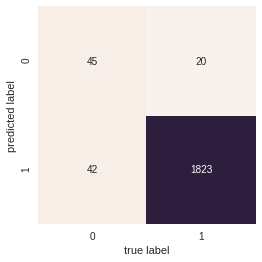

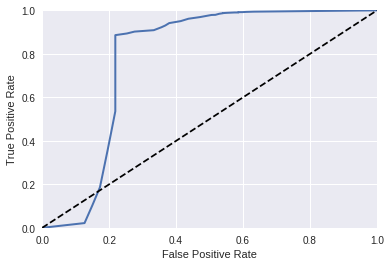

AUC: 0.781622
Score do conjunto de testes: 0.651040 (0.142289) 



MLP
---
              precision    recall  f1-score   support

           0       0.57      0.23      0.33        87
           1       0.96      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.77      0.61      0.65      1930
weighted avg       0.95      0.96      0.95      1930



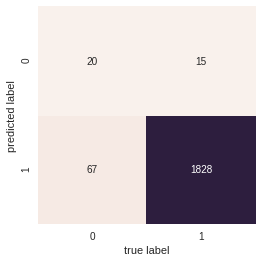

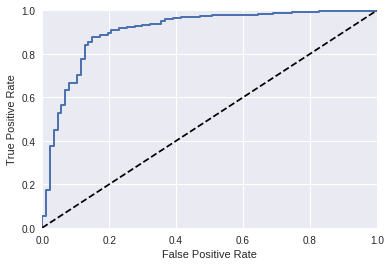

AUC: 0.906325
Score do conjunto de testes: 0.629377 (0.149158) 



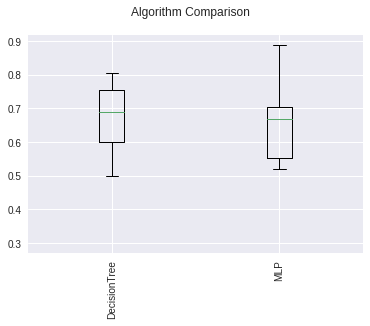

In [8]:
kfold = model_selection.KFold(n_splits=10, random_state=0)

results = []
names = []    

#avaliacao individual por modelo
for model in res_models:        
    print('\n\n'+model['name'])
    print('-'*len(model['name']))

    #sim
    ypred = model['best_model'].predict(Xtest)
    evaluating(model['best_model'], ytest, ypred, Xtest)
    
    #boxplot
    #testa 10 vezes o modelo, a fim de gerar estatística para ser avaliado no p-value
    #cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring='recall_macro') #scoring='accuracy')
    cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring=make_scorer(geometric_mean_score))
    model['cv_results'] = cv_results
    results.append(cv_results)
    names.append(model['name'])
    msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
plot_alg_comp(results, names)

##Utilizando técnicas robustas ao desbalanceamento

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.1min finished


{'n_estimators': 100}
0.8744190245590524
              precision    recall  f1-score   support

           0       0.31      0.82      0.45        87
           1       0.99      0.91      0.95      1843

   micro avg       0.91      0.91      0.91      1930
   macro avg       0.65      0.86      0.70      1930
weighted avg       0.96      0.91      0.93      1930



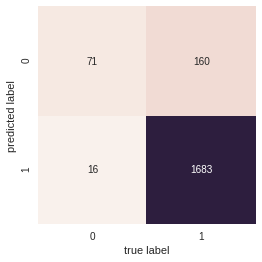

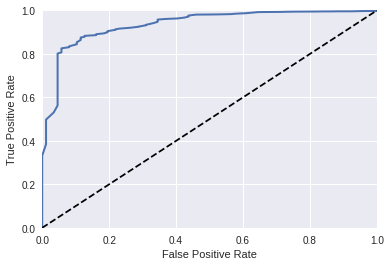

AUC: 0.935416


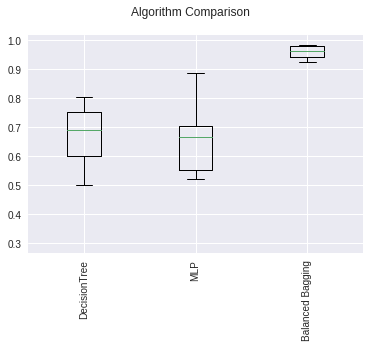

In [9]:
#BalancedBaggingClassifier

#classificador base DT
tree = DecisionTreeClassifier(max_features='auto')

#otimiza parâmetros
parameters = {'n_estimators': (10, 30, 100, 200, 300)}

grid = GridSearchCV(BalancedBaggingClassifier(base_estimator=tree),
                    param_grid=parameters,
                    cv=10, 
                    verbose=1,
                    n_jobs = -1,
                    scoring=make_scorer(geometric_mean_score))
                    #scoring='recall_macro')
                    #scoring='accuracy')

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor modelo
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliacao
evaluating(ensemble, ytest, ypred_ensemble, Xtest)

cv_results = model_selection.cross_val_score(ensemble, Xtest, ypred_ensemble, 
                                             cv=model_selection.KFold(
                                                 n_splits=10, random_state=0),
                                                 scoring=make_scorer(geometric_mean_score))
                                             #scoring='recall_macro')
                                             #scoring='accuracy')

results.append(cv_results)
names.append('Balanced Bagging')

# boxplot algorithm comparison
plot_alg_comp(results, names)

## Teste de p-value, a fim de confirmar se os desempenhos são diferentes

In [10]:
#test p-value 
from scipy.stats import ttest_ind

alpha = 0.05

#test DT x Balanced Bagging
stat, p = ttest_ind(results[0], results[2])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')
  
#test MLP x Balanced Bagging
stat, p = ttest_ind(results[1], results[2])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')
  


Statistics=-6.464, p=0.000
Different distributions (reject H0)
Statistics=-6.604, p=0.000
Different distributions (reject H0)
